# Prepare environment

In [69]:
import cv2
import torch
from matplotlib import pyplot as plt
import numpy as np
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

from dataset.STARCOP_dataset import STARCOPDataset
from dataset.dataset_info import ClassifierDatasetInfo
from dataset.dataset_type import DatasetType
from models.Tools.FilesHandler.model_files_handler import ModelFilesHandler

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load sample images

In [70]:
dataset = STARCOPDataset(
    data_path=r"..\..\..\data",
    data_type=DatasetType.TEST,
    image_info_class=ClassifierDatasetInfo,
    normalization=False
)

dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

# Visualize inputs

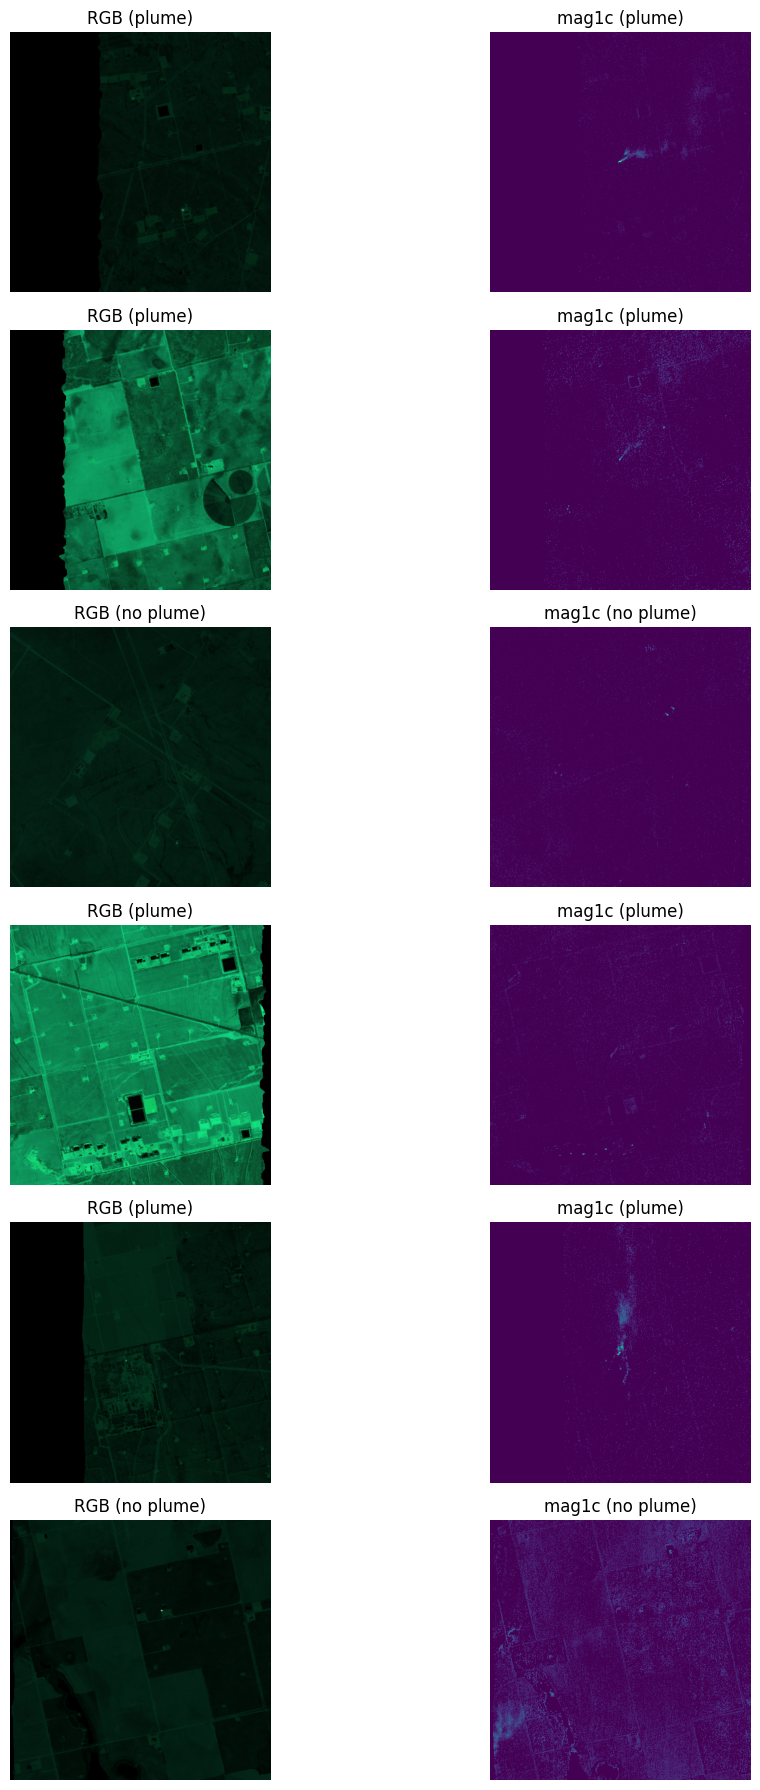

In [71]:
images = next(iter(dataloader))
transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.Normalize(mean=[0.5] * 9, std=[0.5] * 9)  # Normalize for 9 channels
    ])
# Create a figure with subplots
fig, ax = plt.subplots(6, 2, figsize=(12, 18))  # 6 row, 3 columns

# Display the first image
for i in range(images[0].shape[0]):
    image_rgb = images[0][i, :3, :, :].permute(1, 2, 0).numpy()
    image_mag1c = images[1][i].squeeze(0).numpy()
    
    image_rgb = image_rgb - image_rgb.min()  # Shift minimum to 0
    image_rgb = image_rgb / image_rgb.max()  # Scale maximum to 1
    
    plume = images[2][i].item()
    ax[i, 0].imshow(image_rgb)
    ax[i, 0].set_title(f"RGB ({"plume" if plume == True else "no plume"})")
    ax[i, 0].axis('off') 
    
    # Display the second image
    ax[i, 1].imshow(image_mag1c)  # Automatically handles RGB
    ax[i, 1].set_title(f"mag1c ({"plume" if plume == True else "no plume"})")
    ax[i, 1].axis('off')  # Turn off axis
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.tight_layout()
plt.show()

# Prepare input for model 

In [72]:
input_image = torch.cat((images[0], images[1]), dim=1)
input_image = transform(input_image).to(device)

# Prepare model

In [73]:
base_dir = r"..\..\..\trained_models"
file_name = r"model_transformer_classifier_2024_11_27_13_37_10.pickle"

model_handler = ModelFilesHandler(base_dir=base_dir)
model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

CustomViT(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(9, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNo

# Show performance

In [74]:
outputs = model(input_image.to(device))
print(f"Labels:  {images[2].numpy()}")
print(f"Outputs: {torch.argmax(outputs, dim=1).bool().to("cpu").numpy()}")

Labels:  [ True  True False  True  True False]
Outputs: [ True  True False False  True False]


In [75]:
metrics

,TP,FP,FN,TN,Precision,Sensitivity,Specificity,NPV,FPR,Accuracy,F-Score,IoU,MCC,AUC,CI
0,0.249267,0.017595,0.237537,0.495601,0.934062,0.512047,0.965712,0.675999,0.034286,0.744867,0.661476,0.494186,0.539874,0.738881,0.047017
